# Test 9: 65 MB/sec

## producer config

~~~~
limit_bytes_per_seconds=$(( 65 * 1024 * 1024 ))
-Dnum.producers=8 \
-Dproducer.threads=16 \
-Dmin.msg.size=175 \
-Dmax.msg.size=225 \

[kafka.config] {security.protocol=SASL_PLAINTEXT, receive.buffer.bytes=2097152, request.timeout.ms=6000, bootstrap.servers=host1.com:9092,host2.com:9092,host3.com:9092, value.serializer=org.apache.kafka.common.serialization.ByteArraySerializer, send.buffer.bytes=2097152, buffer.memory=536870912, retries=0, key.serializer=org.apache.kafka.common.serialization.IntegerSerializer, client.id=testproducer-001, linger.ms=200, sasl.mechanism=PLAIN, max.in.flight.requests.per.connection=16, batch.size=131072, max.block.ms=20000, acks=1}

~~~~

## consumer config
~~~~
-Dconsumer.threads=32

[kafka.config] {security.protocol=SASL_PLAINTEXT, receive.buffer.bytes=1048576, partition.assignment.strategy=org.apache.kafka.clients.consumer.RoundRobinAssignor, value.deserializer=org.apache.kafka.common.serialization.ByteArrayDeserializer, group.id=stem-dmaap-testconsumer, bootstrap.servers=host1.com:9092,host2.com:9092,host3.com:9092, send.buffer.bytes=1048576, max.partition.fetch.bytes=5242880, fetch.max.wait.ms=5000, client.id=testconsumer-001, key.deserializer=org.apache.kafka.common.serialization.IntegerDeserializer, sasl.mechanism=PLAIN, fetch.min.bytes=16384}
~~~~

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os, os.path
import numpy as np

In [2]:
plt.xkcd(scale=1, length=100, randomness=1)

In [3]:
DATA_DIR='data'

In [4]:
def load_data(csvfile, datadir):
    d = pd.read_csv(os.path.join(datadir, csvfile))
    d['datetime'] = pd.to_datetime(d.date + " " + d.time.str.slice(0,5), 
                                   format="%Y-%m-%d %H:%M") # upto minute only
    d.set_index('datetime', inplace=True)
    return d

def fix_ax(ax):
    ax.set_xlabel('')
    ax.axes.grid(linewidth=0.5)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    return ax

def test_duration_in_hours(t0, t1):
    #print "{} start({}) end({}) {} hours".format(tag, t0, t1, int((t1 - t0).total_seconds()/60/60))
    return int((t1 - t0).total_seconds()/60/60)

In [5]:
data_dir = os.path.join(DATA_DIR, '9')
#data_dir

In [6]:
consumer = load_data('consumer.csv', data_dir)
#consumer.head()

In [7]:
producer = load_data('producer.csv', data_dir)
#producer.head()

## Test Duration

In [8]:
limit=65 # MB
interval = 5  # minutes
freq = '%dT' % interval

delta = pd.Timedelta(4, 'h')
#delta = pd.Timedelta(0, 'h')

#_start = consumer.index.min() + pd.Timedelta(22, 'h')
#_end   = _start + pd.Timedelta(14, 'h')
_start = consumer.index.min()
_end   = consumer.index.max()
consumer2 = consumer[np.logical_and(consumer.index >= _start, consumer.index <= _end)]

#_start = producer.index.min() + pd.Timedelta(22, 'h')
#_end   = _start + pd.Timedelta(14, 'h')
_start = producer.index.min()
_end   = producer.index.max()
producer2 = producer[np.logical_and(producer.index >= _start, producer.index <= _end)]

# 
start    = _start
end      = _end
duration = int((end - start).total_seconds()/60/60)


metdata = pd.DataFrame.from_records(
    zip("start end duration limit interval".split(), (start, end, duration, limit, interval)),
    columns=('name','value'))

metdata.to_csv(os.path.join(data_dir,'metadata.txt'), index=False)

metdata

,name,value
0,start,2018-08-06 10:44:00
1,end,2018-08-07 06:09:00
2,duration,19
3,limit,65
4,interval,5


## Throughput

,count,mean,std,min,25%,50%,75%,max
consumer,233.0,296705.46,4739.73,275634.0,295789.0,296913.0,298280.0,313638.0
producer,233.0,297121.71,3735.52,275859.0,296449.0,297225.0,298187.0,311050.0


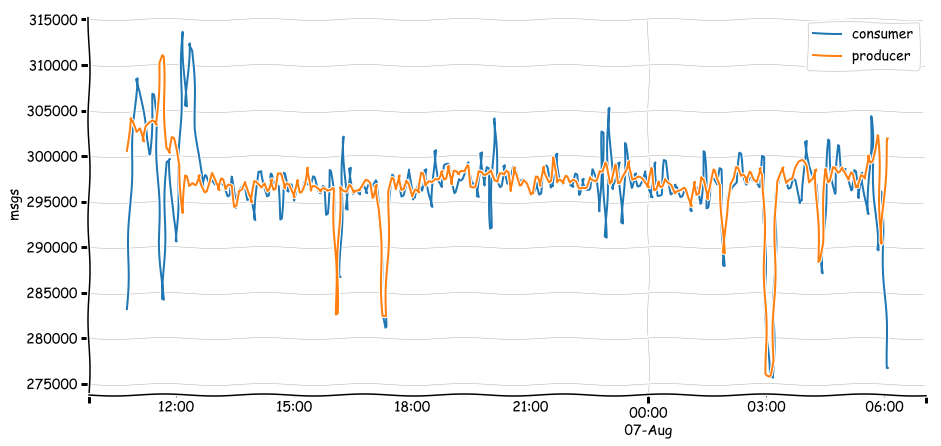

In [9]:
keys = ['consumer','producer']
df = pd.concat([consumer2[['msgs']], producer2[['msgs']]],
               keys=keys,
               axis=1
               )

df2 = df.groupby(pd.Grouper(freq=freq))
df2 = df2.sum()
df2 = df2/(interval*60) # per seconds
df2 = df2.round(2).astype(int)
df2 = df2[1:-1]
df2.columns = df2.columns.droplevel(1)
ax = df2.plot(subplots=False, figsize=(15,7))
fix_ax(ax)
ax.set_ylabel("msgs")
plt.savefig(os.path.join(data_dir, 'img', 'throughput-msgs.svg'))
df3 = df2.describe().T.round(2)
df3.to_csv(os.path.join(data_dir, 'throughput-msgs.txt'), index_label=['type'])
df3

,count,mean,std,min,25%,50%,75%,max
consumer,233.0,58.71,0.94,54.54,58.53,58.76,59.03,62.07
producer,233.0,58.77,0.73,54.59,58.64,58.80,58.98,61.38


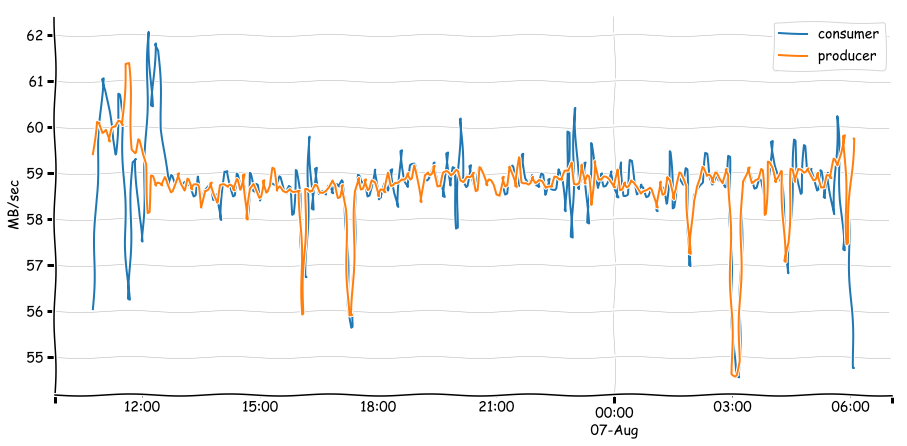

In [10]:
keys=['consumer','producer']
df = pd.concat([consumer2[['bytes']], producer2[['bytes']]],
               keys=keys,
               axis=1)
df2 = df.groupby(pd.Grouper(freq=freq)).sum()
df2 = df2[1:-1]/1024/1024/(interval*60)
df2.columns = df2.columns.droplevel(1)

ax = df2.plot(figsize=(15,7), subplots=False, legend=True)

fix_ax(ax)
ax.set_ylabel("MB/sec")
plt.savefig(os.path.join(data_dir, 'img', 'throughput.svg'))

df3 = df2.describe().T.round(2)
df3.to_csv(os.path.join(data_dir, 'throughput.txt'), index_label=['type'])
df3

## Latency

count      mean        std     min     25%     50%  \
type     percentile                                                       
consumer p95         231.0  21780.99   69676.06   703.4  2607.4  4513.0   
         p99         231.0  37807.22  102390.70  1028.2  5059.2  8792.2   
producer p95         231.0    390.69      97.80   305.8   352.5   375.6   
         p99         231.0    705.65     232.56   425.2   567.4   642.0   

                         75%        max  
type     percentile                      
consumer p95          7912.4  501267.36  
         p99         16549.1  639298.60  
producer p95           401.0    1121.40  
         p99           760.6    2469.40

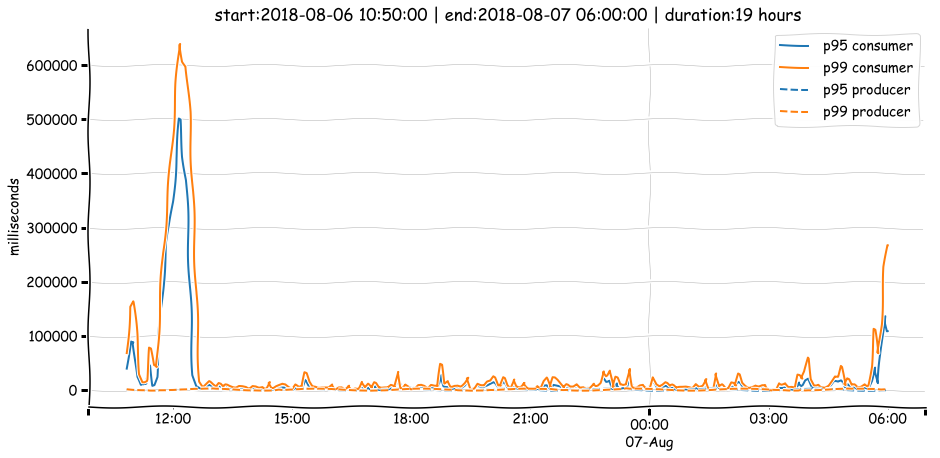

In [11]:
def lat_histo_p(d):
    d = d[d.columns[d.columns.str.startswith('lat_histo_p')]]
    d.columns = d.columns.str.replace('lat_histo_','')
    return d[1:-1]

df = pd.concat([lat_histo_p(consumer2), lat_histo_p(producer2)],
               keys=['consumer','producer'],
               names=['type'],
               axis=1
              )
df2 = df.loc[:, (slice(None), ('p95','p99'))]
df2 = df2.groupby(pd.Grouper(freq=freq)).mean().round(2)
df2 = df2[1:-1]

ax = df2.plot(figsize=(15,7), 
              subplots=False, 
              sharex=True, 
              sharey=True,
              style=['-','-','--','--'],
              color=['#1f77b4', '#ff7f0e']
             )
fix_ax(ax)
ax.legend().set_title('')
ax.set_title("start:{} | end:{} | duration:{} hours".format(
    df2.index.min(), 
    df2.index.max(), 
    int((df2.index.max() - df2.index.min()).total_seconds()/60/60)))

ax.set_ylabel('milliseconds')

handles, labels = ax.get_legend_handles_labels()
labels = map(lambda s: "{1} {0}".format(*s[1:-1].split(",")), labels)
ax.legend(handles, labels)

plt.savefig(os.path.join(data_dir, 'img', 'latency.svg'))

df3 = df2.describe().round(2).T
df3.index.names = ['type','percentile']
df3.to_csv(os.path.join(data_dir, 'latency.txt'))
df3

count     mean      std     min     25%     50%  \
type     percentile                                                    
consumer p95         147.0  5228.47  4770.57   810.4  2361.2  3910.2   
         p99         147.0  9871.10  8290.93  1308.0  4502.3  7659.0   
producer p95         147.0   375.57    79.77   314.2   344.6   366.0   
         p99         147.0   649.60   169.52   468.2   556.5   611.6   

                          75%      max  
type     percentile                     
consumer p95          5733.80  28134.6  
         p99         11171.74  48113.2  
producer p95           385.30   1042.0  
         p99           696.80   1688.0

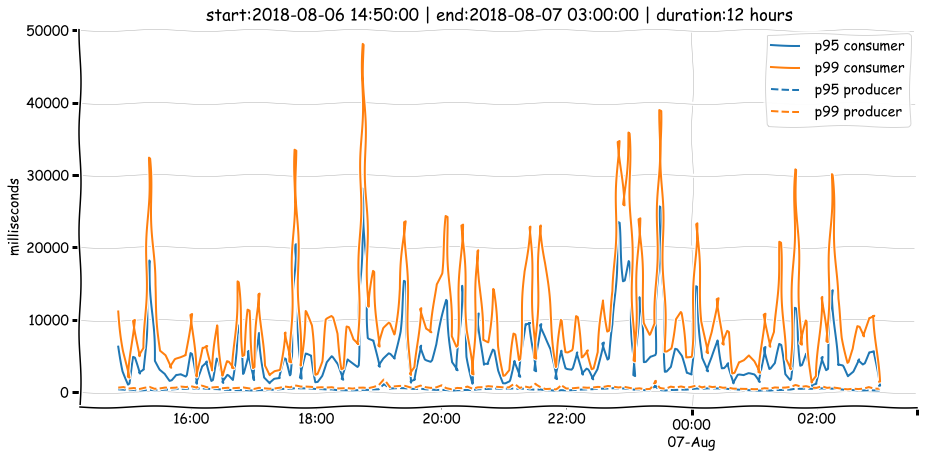

In [12]:
df21 = df2[np.logical_and(df2.index >= df2.index.min() + pd.Timedelta(4,"h"),
               df2.index <= df2.index.max() - pd.Timedelta(3,"h"))]

ax = df21.plot(figsize=(15,7), 
              subplots=False, 
              sharex=True, 
              sharey=True,
              style=['-','-','--','--'],
              color=['#1f77b4', '#ff7f0e']
             )
fix_ax(ax)
ax.set_title("start:{} | end:{} | duration:{} hours".format(
    df21.index.min(), 
    df21.index.max(), 
    int((df21.index.max() - df21.index.min()).total_seconds()/60/60)))
ax.set_ylabel('milliseconds')

handles, labels = ax.get_legend_handles_labels()
labels = map(lambda s: "{1} {0}".format(*s[1:-1].split(",")), labels)
ax.legend(handles, labels)

plt.savefig(os.path.join(data_dir, 'img', 'latency-zoom.svg'))

df3 = df21.describe().round(2).T
df3.index.names = ['type','percentile']
df3.to_csv(os.path.join(data_dir, 'latency-zoom.txt'))
df3

0 days 19:25:00
start=2018-08-06 10:45:00 end=2018-08-07 06:10:00
ploting start=2018-08-06 10:45:00 end=2018-08-07 06:10:00 interval=0 days 19:25:00


Text(0.5,1,'end-to-end latency\nstart=08/06 10:45 | end=08/07 06:10 | interval=19.42 hrs')

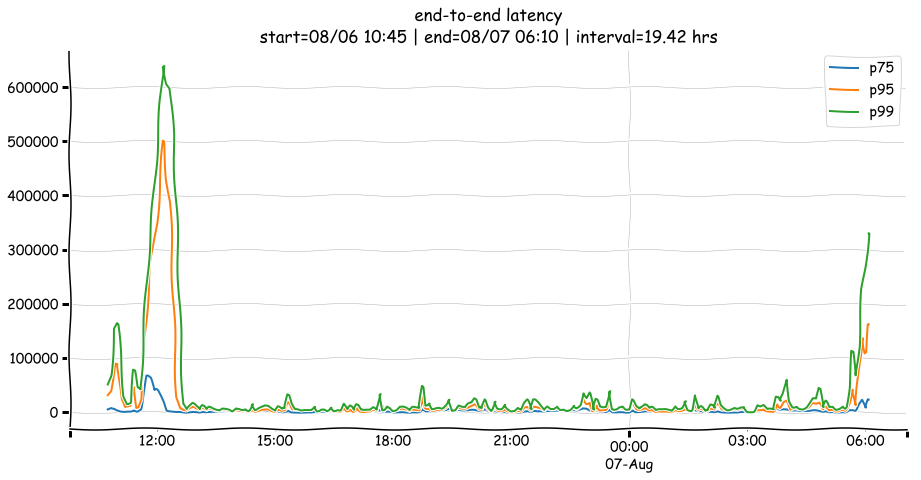

In [13]:
print consumer.index.max() - consumer.index.min()
#start = consumer.index.max() - pd.Timedelta(10, unit='m') # 'ns', 'us', 'ms', 's', 'm', 'h', 'D'
start = consumer.index.min() + pd.Timedelta(0, unit='m')
end   = consumer.index.max() - pd.Timedelta(0, unit='m')
print "start={} end={}".format(start, end)
consumer2 = consumer[np.logical_and(consumer.index >= start, consumer.index <= end)]
print "ploting start={} end={} interval={}".format(consumer2.index.min(), consumer2.index.max(),
                                   consumer2.index.max() - consumer2.index.min())
ax = lat_histo_p(consumer2)[['p75', 'p95','p99']].groupby(pd.Grouper(freq='5T')).mean().plot(figsize=(15,7))
fix_ax(ax)
#plt.savefig(os.path.join(data_dir, 'img', 'latency-zoom.svg'))
ax.set_title("end-to-end latency\nstart={} | end={} | interval={} hrs".format(
    consumer2.index.min().strftime("%m/%d %H:%M"), 
    consumer2.index.max().strftime("%m/%d %H:%M"), 
    round((consumer2.index.max() - consumer2.index.min()).total_seconds()/60/60,2)
))

## Success

,msgs,success,error
datetime,,,
2018-08-06 08:00:00,1379813129,1378802367,1010738
2018-08-06 12:00:00,4273583113,4271297806,2285115
2018-08-06 16:00:00,4264616245,4262705814,1910255
2018-08-06 20:00:00,4284835372,4282977525,1857654
2018-08-07 00:00:00,4258925918,4256455587,2470119
2018-08-07 04:00:00,2320516474,2319744577,771786


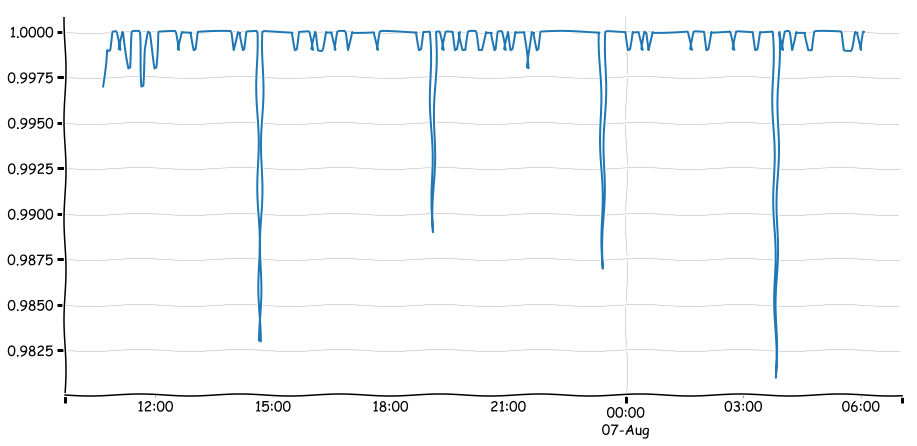

In [14]:
df = pd.DataFrame({
    'success': producer2.apply(lambda row: row.msgs if row.success > row.msgs else row.success, axis=1),
    'msgs'   : producer2.msgs, 
    'error'  : producer2.error,
    }, 
    index=producer2.index)
df['success_ratio']=df.success/df.msgs

df2 = df['success_ratio'].groupby(pd.Grouper(freq=freq)).mean().round(3)
axes = df2.plot(figsize=(15,7), legend=False)
axes = map(fix_ax, [axes])
plt.savefig(os.path.join(data_dir, 'img', 'success.svg'))

df3 = df[['msgs','success','error']].groupby(pd.Grouper(freq='4H')).sum()
df3.to_csv(os.path.join(data_dir, 'success.txt'))
df3